In [22]:
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import os

#Gets the path of current directory
dir=os.path.realpath('.')
#Lists files in current directory, excluding child directories
list_files=list(os.walk(dir))[0][2]
#Selects final_data csv file name
final_data_file_name=[file for file in list_files if 'final_data' in file][0]
if len(final_data_file_name)==0:
    print('There is not final data file')
else:
    #Generates dataframe from file
    df=pd.read_csv(final_data_file_name)

Calculation days on market for each property

In [23]:
start_date=datetime.date(2022,9,30)
finish_date=datetime.date.today()
delta=datetime.timedelta(days=1)

#creates the file names to date
def get_names(start_date): 
    file_names=[]
    while start_date<=finish_date: 
        file_names.append('clean_{}.csv'.format(start_date))
        start_date+=delta
    return file_names

#get the files if they exist
def get_files(file_names):
    frames=[]
    for file_name in file_names:
        try:
            #'right_to_move_files' is the directory with all the files
            df=pd.read_csv('clean_right_to_move_files/'+file_name) #right_to_move_files is the directory with all the files
            frames.append(df)
        except:
            print("File {} not found".format(file_name))
            continue

    return frames
#Function to drop duplicates within each dataframe/day
def drop_dupl(frames):
    drop_duplicates_frames=[frame.drop_duplicates(subset=['description'])for frame in frames]

    return drop_duplicates_frames

#Time to use the previous built functions
#Gets the file names
frame_names=get_names(start_date)
#Opens the files if they exist
frames=get_files(frame_names)
#Drops duplicates within each data frame
frs=drop_dupl(frames)

#Counts the number of time each url appears in the concatenated dataframe
#to find out how many days each property has been in the market
df_days_on_market=(
    #Concateantes all the dataframes
    pd.concat(frs,ignore_index=True)
    ['description']
    .value_counts()
    .reset_index()
)
#Merges this data with the original property dataframe matching each url and renames variable 'count'
df=pd.merge(df,df_days_on_market,on='description').rename(columns={'count':'days_on_market'})


File clean_2022-10-09.csv not found
File clean_2022-11-12.csv not found
File clean_2022-11-29.csv not found
File clean_2023-01-10.csv not found
File clean_2023-01-11.csv not found
File clean_2023-01-12.csv not found
File clean_2023-01-13.csv not found
File clean_2023-01-14.csv not found
File clean_2023-01-15.csv not found
File clean_2023-01-16.csv not found
File clean_2023-01-17.csv not found
File clean_2023-02-04.csv not found
File clean_2023-02-05.csv not found
File clean_2023-02-06.csv not found
File clean_2023-02-08.csv not found
File clean_2023-02-09.csv not found
File clean_2023-02-10.csv not found
File clean_2023-02-20.csv not found
File clean_2023-02-21.csv not found
File clean_2023-02-22.csv not found
File clean_2023-02-23.csv not found
File clean_2023-02-24.csv not found
File clean_2023-02-25.csv not found
File clean_2023-03-16.csv not found
File clean_2023-03-29.csv not found
File clean_2023-03-30.csv not found
File clean_2023-03-31.csv not found
File clean_2023-04-01.csv no

Proportion of null values for each column

In [24]:
print('df.shape:',df.shape)
round(
(df.isna().sum()/df.shape[0])
.sort_values(ascending=False)
,2
)

df.shape: (5798, 20)


longitude                            0.99
latitude                             0.99
letting_agent_registration_number    0.32
landlord_registration_number         0.22
postcode_district                    0.20
let_type                             0.14
EPC_rating                           0.14
bathrooms                            0.13
property_type                        0.02
bedrooms                             0.02
min_tenancy                          0.00
agent_name                           0.00
let_available_date                   0.00
deposit                              0.00
furnish_type                         0.00
price                                0.00
address                              0.00
date                                 0.00
description                          0.00
days_on_market                       0.00
dtype: float64

Number of properties published by date

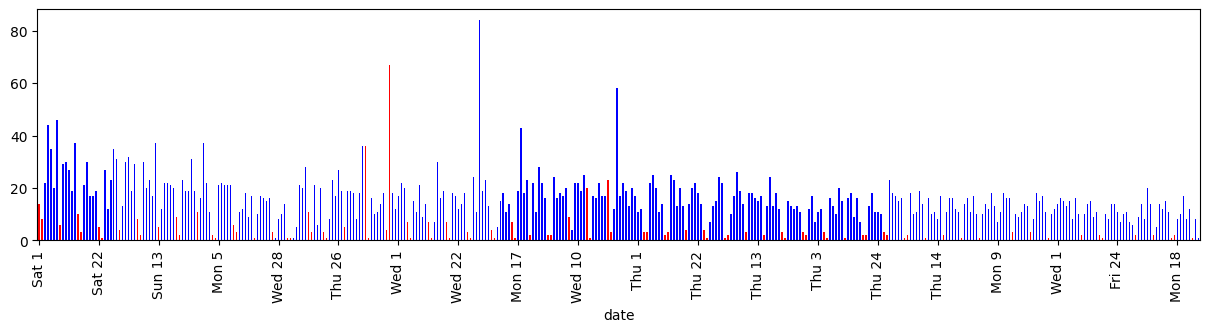

In [25]:
prop_per_date=df['date'].value_counts().sort_index()[1:]
week=['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

#This eliminates some outliers due to periods when there was no data extraction
prop_per_date=prop_per_date[prop_per_date<100]

#Creates a dictionary with days of the week instead of dates
change_index=(
    #Dictionary comprehension to change dates to weekdays 
    {str(pd.to_datetime(date).date())
    :str(week[pd.to_datetime(date).weekday()])+' '+str(pd.to_datetime(date).day)
 for date in prop_per_date.index}
)
#Define 'red' for weekend days and 'blue' for weekdays as colorbar
bar_colors=['r' if ('Sat' in day or 'Sun' in day) 
else 'b' for day in change_index.values()]

(
prop_per_date
.rename(index=change_index)
.plot(kind='bar',figsize=(15,3),color=bar_colors)
)
plt.xticks(np.arange(0,400,20))
plt.show()



Distribution by price

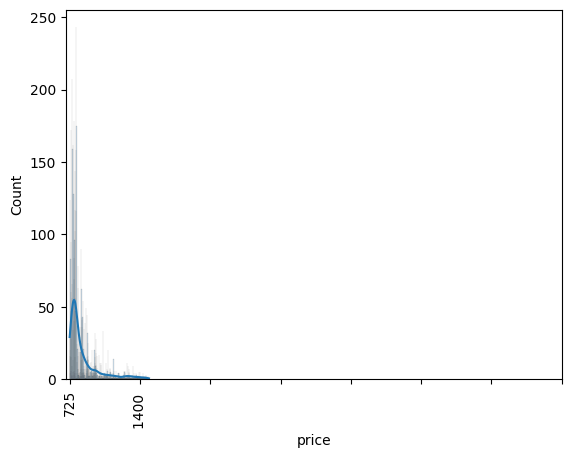

In [26]:
sns.histplot(data=df,x='price',fill=True,alpha=0.2,kde=True,bins=np.arange(0,5000,200))
plt.xticks(np.arange(0,4000,500),rotation=90)
plt.show()

In [27]:
df['price']=pd.to_numeric(df['price'],errors='coerce')

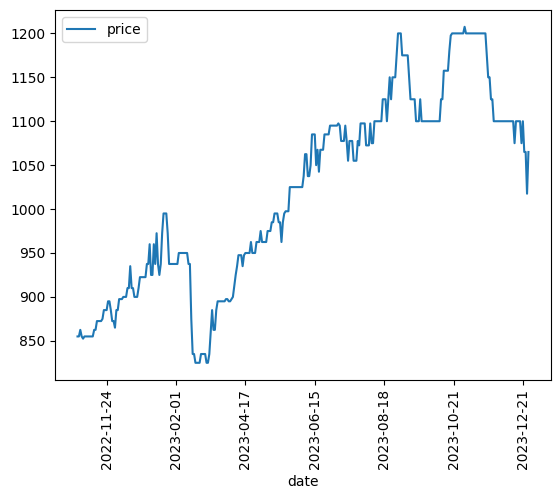

In [28]:
df.query(f'bedrooms==2 & bathrooms==1')[['price','date']].groupby('date').min().rolling(30).median().plot()
plt.xticks(rotation=90)
plt.show()

Agents market share by number of properties published

<Axes: xlabel='agent_name'>

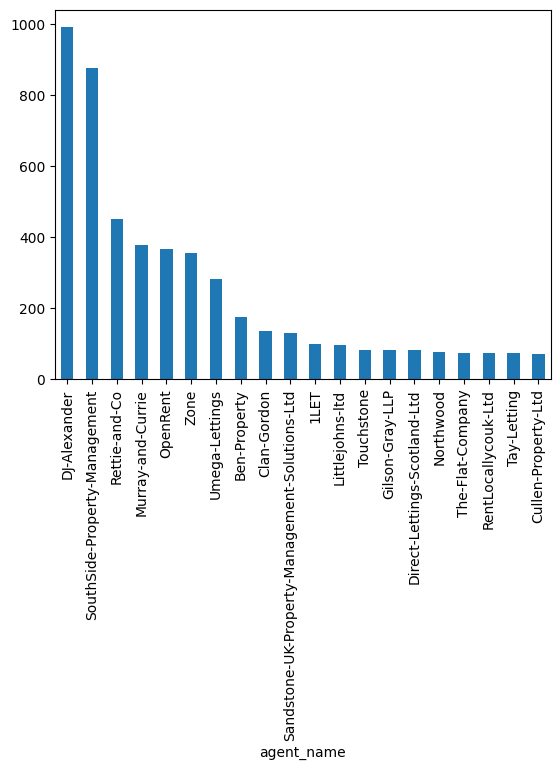

In [29]:
(
    df['agent_name']
    .value_counts(sort=True,ascending=False)
    .head(20)
    .plot(kind='bar')
)

Distribution by number of bedrooms and bathrooms

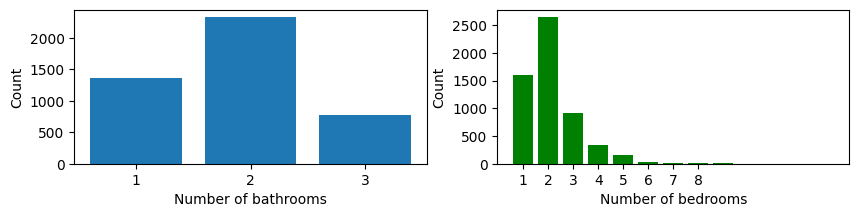

In [30]:
fig,(ax_1,ax_2)=plt.subplots(1,2,figsize=(10,2))
df_plot_bathrooms=df.query('bathrooms<=2 & bedrooms <=3')['bathrooms'].value_counts().sort_index()
df_plot_bathrooms=df.query('bathrooms<=2 & bedrooms <=3')['bedrooms'].value_counts().sort_index()
ax_1.bar(height=df_plot_bathrooms.values,
        x=df_plot_bathrooms.index
        )
ax_1.set_xlabel('Number of bathrooms')
ax_1.set_ylabel('Count')
ax_1.set_xticks(list(range(1,4)))
ax_1.set_yticks(list(range(0,
                        df_plot_bathrooms.values.max(),
                        500)))

ax_2.bar(height=df['bedrooms'].value_counts().sort_index().values,
        x=df['bedrooms'].value_counts().sort_index().index,
        color='green'
        )
ax_2.set_xlabel('Number of bedrooms')
ax_2.set_ylabel('Count')
ax_2.set_xticks(list(range(1,9)))
ax_2.set_yticks(list(range(0,
                        df['bedrooms'].value_counts().sort_index().values.max(),
                        500)))
plt.show()

Distribution by property type

/tmp/ipykernel_16159/3608557114.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(prop_type.index,rotation=90)


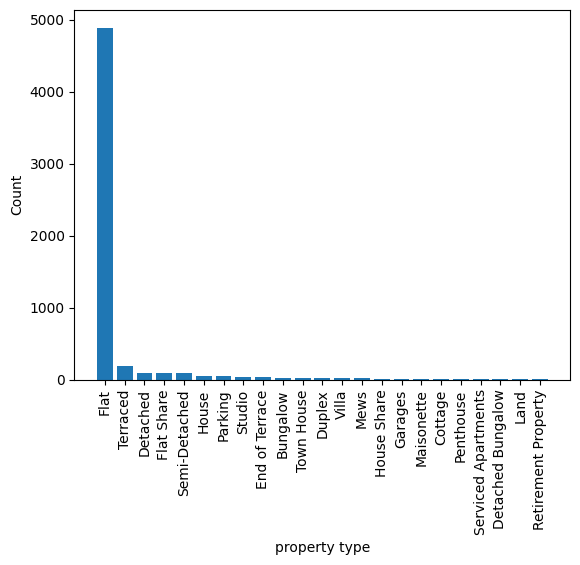

In [31]:
prop_type=df['property_type'].value_counts().sort_values(ascending=False)
fig,ax=plt.subplots()
ax.bar(height=prop_type.values,
        x=prop_type.index
        )
ax.set_xlabel('property type')
ax.set_ylabel('Count')
ax.set_xticklabels(prop_type.index,rotation=90)
plt.show()

Proportion of properties that are not flats

In [32]:
flats=(
df[df['property_type']=='Flat']['property_type']
.value_counts()
.sum()/df.shape[0]
)
print('Percentaje of flats:',round(flats*100,1),'%')

Percentaje of flats: 84.4 %


 Changing values 'Now' and 'Ask Agent' from let_available_date' column (Part of this should be in the cleaning section)

In [33]:
now_index=df[df['let_available_date']=='Now'].index
df.loc[now_index,'let_available_date']=df.loc[now_index,'date']

ask_agent_index=df[df['let_available_date']=='Ask agent'].index
df.loc[ask_agent_index,'let_available_date']=pd.NA

df['let_available_date']=pd.to_datetime(df['let_available_date'],
                                        errors='coerce',
                                        format='%d/%m/%Y').dt.date



Converting 'date' columns to datetime (This also should be in the cleaning section)

In [34]:
df['date']=df['date'].astype('datetime64[ns]').dt.date

Distribution of days properties last published in the market

<Axes: xlabel='days_on_market'>

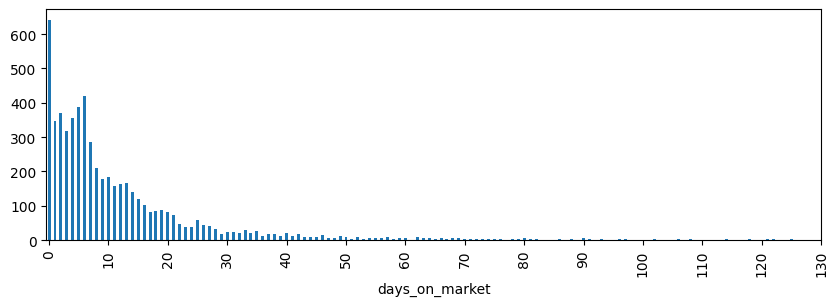

In [35]:
df['days_on_market'].value_counts().sort_index().plot(kind='bar',figsize=(10,3),xticks=range(0,140,10))

Analysis acording if they have min tenancy period

In [36]:
df['min_tenancy'].value_counts().sort_values(ascending=False)

min_tenancy
Ask agent    5344
6 months      391
12 months      36
36 months      10
48 months       6
24 months       3
3 months        1
4 months        1
11 months       1
44 months       1
10 months       1
Name: count, dtype: int64

Short term or long term rent

In [37]:
df['let_type'].value_counts()

let_type
Long term     4964
Short term      16
Name: count, dtype: int64

Furnished or unfurnished property

In [38]:
round(
df['furnish_type'].value_counts()/df.shape[0]*100
,2
)

furnish_type
Furnished                   66.59
Unfurnished                 27.25
Part furnished               2.79
Ask agent                    2.45
Furnished or unfurnished     0.90
Name: count, dtype: float64

Bivariant analysis- Prices vs number of bedrooms

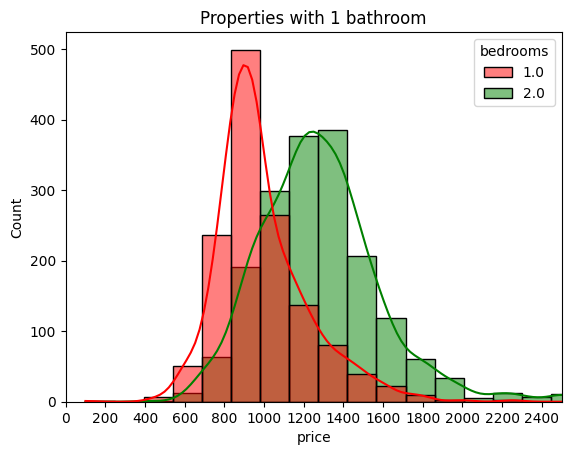

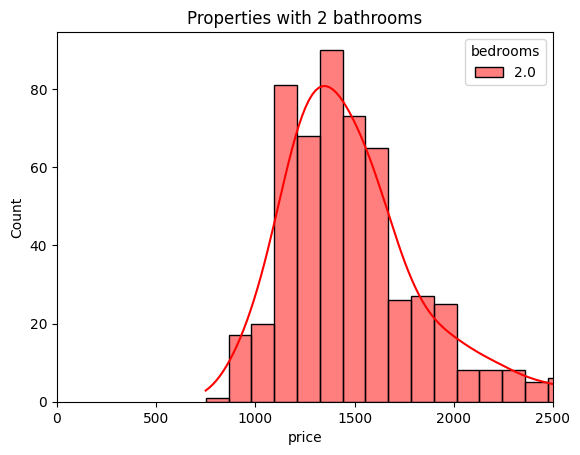

In [39]:
sns.histplot(data=df[(df['bedrooms']<3) & (df['bathrooms']==1)],
            x='price',
            hue='bedrooms',
            palette=['red','green'],
            fill=True,
            alpha=0.5,
            kde=True,
            bins=30
            )
#Plot formatting
plt.xlim(0,2500)
plt.xticks(list(range(0,2500,200)))
plt.title('Properties with 1 bathroom')
plt.show()

sns.histplot(data=df[(df['bedrooms']==2) & (df['bathrooms']==2)],
            x='price',
            hue='bedrooms',
            fill=True,
            palette=['red'],
            alpha=0.5,
            kde=True,
            bins=30,
            )
plt.xlim(0,2500)
plt.title('Properties with 2 bathrooms')
plt.show()

Bivariant analysis- Prices vs number of bedrooms (outliers excluded)

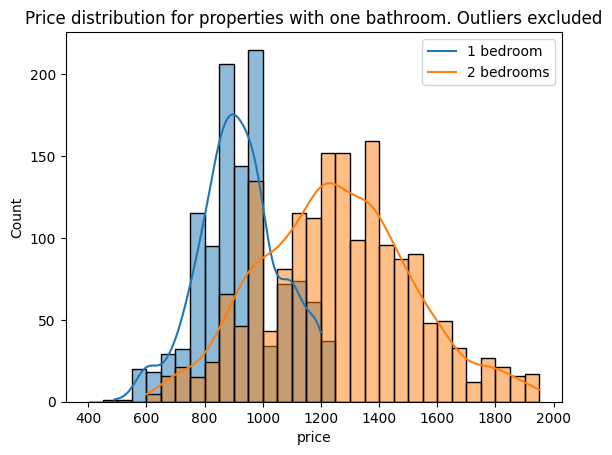

In [40]:
room1_q1,room1_q3=df[(df['bedrooms']==1) & (df['bathrooms']==1)]['price'].quantile(q=[0.25,0.75])
room2_q1,room2_q3=df[(df['bedrooms']==2) & (df['bathrooms']==1)]['price'].quantile(q=[0.25,0.75])

room1_lim_inf=room1_q1-(room1_q3-room1_q1)*1.5
room1_lim_sup=room1_q3+(room1_q3-room1_q1)*1.5

room2_lim_inf=room2_q1-(room2_q3-room2_q1)*1.5
room2_lim_sup=room2_q3+(room2_q3-room2_q1)*1.5

data_1_room=df[(df['bedrooms']==1) &
                (df['price']>room1_lim_inf) &
               (df['price']<=1200) &
                (df['bathrooms']==1)]

data_2_room=df[(df['bedrooms']==2) &
                (df['price']>room2_lim_inf) &
                (df['price']<room2_lim_sup) &
                (df['bathrooms']==1)]

sns.histplot(data=data_1_room,
            x='price',
            fill=True,
            alpha=0.5,
            kde=True,
            bins=np.arange(400,2000,50),
            #stat='probability'
            )

sns.histplot(data=data_2_room,
            x='price',
            fill=True,
            alpha=0.5,
            kde=True,
            bins=np.arange(400,2000,50),
            #stat='probability'
            )

plt.legend(['1 bedroom','2 bedrooms'])
plt.title('Price distribution for properties with one bathroom. Outliers excluded')
plt.show()


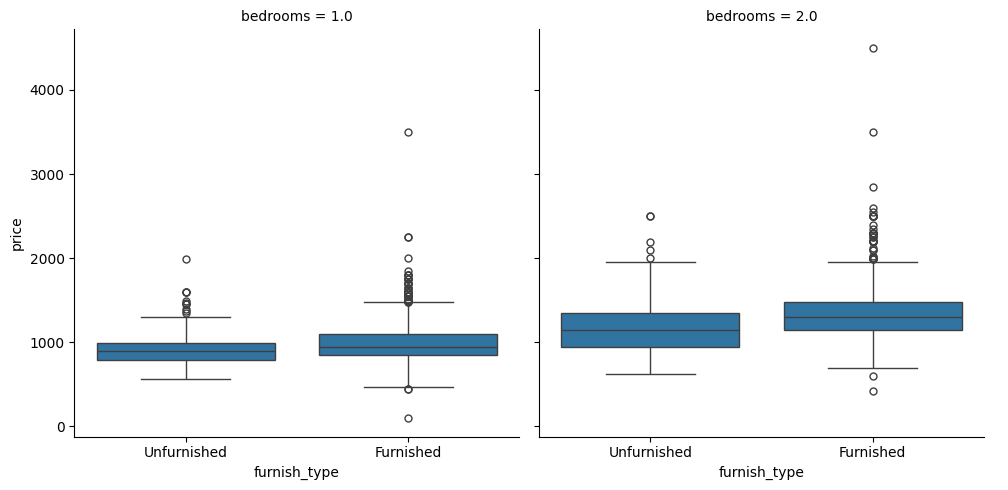

In [41]:
sns.catplot(data=df.query('bathrooms==1 &\
                        bedrooms<=2 &\
                        furnish_type in ["Furnished", "Unfurnished"]'),
            y='price',x='furnish_type',col='bedrooms',kind='box')




Normal disribution fit for properties with one bathroom and one bedroom

NameError: name 'norm' is not defined

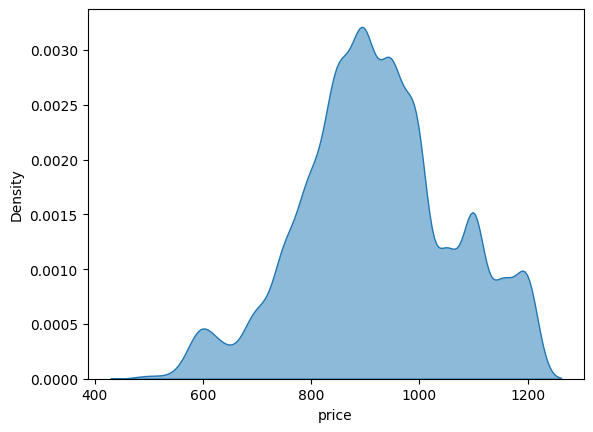

In [42]:
#property prices for 1 bedroom flat adjust to a norrmal distribution for flats below 1200 pcm.
#There is the need to find out if properties above 1200pcm are part of this population or they 
#are part of a different one.
sns.kdeplot(data=data_1_room,
            x='price',
            fill=True,
            alpha=0.5,
            common_norm=True,
            bw_adjust=0.6
            )

mu,std=norm.fit(data_1_room['price'])

x=np.linspace(400,2500)
normal_dist=norm.pdf(x,mu,std)
plt.plot(x,normal_dist,'r',linewidth=2,linestyle='dashed')
plt.show()


Normal disribution fit for properties with one bathroom and two bedrooms

NameError: name 'norm' is not defined

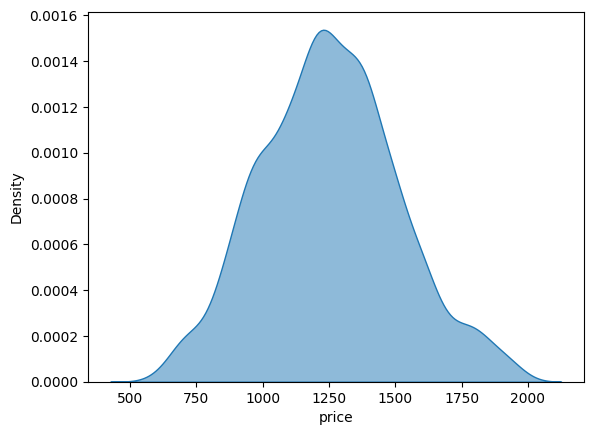

In [43]:
sns.kdeplot(data=data_2_room,
            x='price',
            fill=True,
            alpha=0.5,
            common_norm=True,
            bw_adjust=1
            )

mu,std=norm.fit(data_2_room['price'])

x=np.linspace(400,2500)
normal_dist=norm.pdf(x,mu,std)
plt.plot(x,normal_dist,'r',linewidth=2,linestyle='dashed')
plt.show()

Price distribution for each one of the 10 main agents

In [ ]:
main_agents=(df['agent_name']
                    .value_counts(sort=True,ascending=False)
                    .head(10)
                    )
main_agents_index=main_agents.index.tolist()
                    
df_main_agents=df[df['agent_name'].isin(main_agents_index)]

sns.boxplot(data=df_main_agents.query('bedrooms<3'),
                x='agent_name',
                y='price',
                hue='bedrooms')
#sns.stripplot(data=df_main_agents.query('bedrooms<3'),
#                x='agent_name',
#                y='price',
#                hue='bedrooms',
#                dodge=True)

plt.xticks(rotation=90)
plt.show()

Price distribution by furnish type, number of bathrooms and number of bedrooms

In [ ]:
classification=df[(df['bedrooms']<=2) &
                (df['bathrooms']<=2) &
            (df['furnish_type'].isin(['Furnished','Unfurnished']))
]
round(
classification.groupby(['bathrooms','bedrooms','furnish_type'])['price']
.agg(['median','mean','std','count'])
,0
)
sns.displot(data=classification,
            x="price",
            col="bedrooms",
            row="bathrooms",
            hue="furnish_type",
            height=5,
            aspect=1.5
            )

Analysis days_on_market vs price vs number of bedrooms

In [ ]:

#for i in range(1,5):
#    plt.figure(figsize=(7,1))
#    plt.ylim(0,60)
#    (
#    df[df['bedrooms']==i]['days_on_market']
#    .value_counts()
#    .sort_index()
#    .plot(kind='bar')
#    )
#    
#    plt.title('days on the market - {} bedrooms'.format(i))
#    plt.show()
    
data=df.query('bedrooms<=5')
plt.figure(figsize=(5,5))
sns.boxplot(data=data,y='days_on_market',x='bedrooms')
sns.stripplot(data=data,y='days_on_market',x='bedrooms')
plt.show()

Analysis EPC vs price vs number of bedrooms

In [ ]:
EPC=(
df[
(df['EPC_rating'].isin(['A','B','C','D','E','F','G']))
& 
(df['bedrooms']<=4)
]
[['EPC_rating','price','bedrooms']]
.sort_index()
)


#there is no influence of the EPC in the price of the properties
sns.stripplot(data=EPC,y='price',x='EPC_rating',hue='bedrooms',dodge=True,alpha=0.25,order=['A','B','C','D','E','F','G'])
sns.boxplot(data=EPC,y='price',x='EPC_rating',hue='bedrooms',order=['A','B','C','D','E','F','G'])


In [ ]:
council_tax=(
df[(df['bathrooms']==1) & (df['bedrooms']<4) ][['council_tax_band','price','bedrooms']]
.sort_values('council_tax_band')
)


#there is no influence of the EPC in the price of the properties
sns.stripplot(data=council_tax,y='price',x='council_tax_band',color='red',alpha=0.5,hue='bedrooms',dodge=True)
sns.boxplot(data=council_tax,y='price',x='council_tax_band',hue='bedrooms')

plt.show()


In [ ]:
data=df[
(df['bathrooms']==1)
& 
(df['bedrooms']==1)
]
round(
    data.groupby(['bathrooms','bedrooms','postcode_district','council_tax_band','furnish_type'])['price']
    .agg(['median','mean','std','count'])
    .sort_values('count',ascending=False)
    ,0
)


In [ ]:
data=df[
(df['bathrooms']==1)
& 
(df['bedrooms']==1)
&
(df['postcode_district']=='EH{}'.format(11))
# &
# (df['council_tax_band']=='B')
&
(df['furnish_type']=='Furnished')

]
sns.histplot(data=data,x='price',bins=np.arange(700,1300,25))


In [ ]:
(df.groupby('postcode_district')
    .count()
    ['url']
    .sort_values(ascending=False)
    .plot(kind='bar',figsize=(5,2))
)

In [ ]:
#Trying to find out if there is a time pattern in property
# publications based on postcode district
for i in range(1,13): 
    (df.groupby(['postcode_district','date'])
    .count()
    ['url']
    .reset_index()
    .rename(columns={'url':'num_properties'})
    .query('postcode_district=="EH{}"'.format(i))
    .set_index('date')
    [1:]
    .plot(kind='bar',figsize=(12,3),title='EH{}'.format(i))
    )